**QUESTION 2 - SPECTER embedding and PCA**

**Tahir Manuel D Mello  
BIS634 Assignment 3**

In [1]:
import pickle
import xml.etree.ElementTree as ET
import seaborn as sns

Load the papers dictionary. **(3 points)**

Keep track of which papers came from searching for Alzheimers, which came from searching for cancer. **(5 points)**

In [2]:
alzheimers_dict = pickle.load( open( "dictionary_Alzheimers.pkl", "rb" ) )
cancer_dict = pickle.load( open( "dictionary_cancer.pkl", "rb" ) )

In [3]:
alzheimers_dict

{'36328129': {'ArticleTitle': "Transcranial Deep-tissue Phototherapy for Alzheimer's Disease using Low-Dose X-ray-Activated Long-Afterglow Scintillators.",
  'AbstractText': [[b"<Abstract><AbstractText>Non-invasive phototherapy has been emerging as an ambitious tactic for suppression of amyloid-&#946; (A&#946;) self-assembly against Alzheimer's disease (AD). However, it remains a daunting challenge to develop efficient photosensitizers for A&#946; oxygenation that are activatable in a deep brain tissue through the scalp and skull, while reducing side effects on normal tissues. Here, we report an A&#946; targeted, low-dose X-ray-excitable long-afterglow scintillator (ScNPs@RB/Ab) for efficient deep-brain phototherapy. We demonstrate that the as-synthesized ScNPs@RB/Ab is capable of converting X-rays into visible light to activate the photosensitizers of rose bengal (RB) for A&#946; oxygenation through the scalp and skull. We show that the ScNPs@RB/Ab persistently emitting visible lumine

In [4]:
cancer_dict

{'36328436': {'ArticleTitle': 'Use of the ISUP e-learning module improves interrater reliability in prostate cancer grading.',
  'AbstractText': [[b'<Abstract><AbstractText Label="AIMS" NlmCategory="OBJECTIVE">Prostate cancer (PCa) grading is an important prognostic parameter, but is subject to considerable observer variation. Previous studies have shown that interobserver variability decreases after participants were trained using an e-learning module. However, since the publication of these studies, grading of PCa has been enhanced by adopting the International Society of Urological Pathology (ISUP) 2014 grading classification. This study investigates the effect of training on interobserver variability of PCa grading, using the ISUP Education web e-learning on Gleason grading.</AbstractText><AbstractText Label="METHODS" NlmCategory="METHODS">The ISUP Education Prostate Test B Module was distributed among Dutch pathologists. The module uses images graded by the ISUP consensus panel co

In [5]:
#Preprocessing to convert XML list abstract to string. 

alzheimers_paper_id = list(alzheimers_dict.keys())

for id_list in alzheimers_paper_id:
    
    if alzheimers_dict[str(id_list)]['AbstractText'] == [] or len(alzheimers_dict[str(id_list)]['AbstractText'][0][0]) < 30:
        alzheimers_dict[id_list]['AbstractText'] = ""
        continue
         
    item = alzheimers_dict[str(id_list)]['AbstractText'][0][0] #Choose saved xml format string
    tree = ET.ElementTree(ET.fromstring(item))
    root = tree.getroot()
    
    for child in root:
        if child.tag == 'CopyrightInformation':
            root.remove(child) 
    
    alzheimers_dict[id_list]['AbstractText'] = ET.tostring(root, method="text").decode()

alzheimers_dict

{'36328129': {'ArticleTitle': "Transcranial Deep-tissue Phototherapy for Alzheimer's Disease using Low-Dose X-ray-Activated Long-Afterglow Scintillators.",
  'AbstractText': "Non-invasive phototherapy has been emerging as an ambitious tactic for suppression of amyloid-&#946; (A&#946;) self-assembly against Alzheimer's disease (AD). However, it remains a daunting challenge to develop efficient photosensitizers for A&#946; oxygenation that are activatable in a deep brain tissue through the scalp and skull, while reducing side effects on normal tissues. Here, we report an A&#946; targeted, low-dose X-ray-excitable long-afterglow scintillator (ScNPs@RB/Ab) for efficient deep-brain phototherapy. We demonstrate that the as-synthesized ScNPs@RB/Ab is capable of converting X-rays into visible light to activate the photosensitizers of rose bengal (RB) for A&#946; oxygenation through the scalp and skull. We show that the ScNPs@RB/Ab persistently emitting visible luminescence can substantially mi

In [6]:
cancer_paper_id = list(cancer_dict.keys())

for id_list in cancer_paper_id:
    
    if cancer_dict[str(id_list)]['AbstractText'] == [] or len(cancer_dict[str(id_list)]['AbstractText'][0][0]) < 30:
        cancer_dict[id_list]['AbstractText'] = ""
        continue
         
    item = cancer_dict[str(id_list)]['AbstractText'][0][0] #Choose saved xml format string
    tree = ET.ElementTree(ET.fromstring(item))
    root = tree.getroot()
    
    for child in root:
        if child.tag == 'CopyrightInformation':
            root.remove(child) 
    
    cancer_dict[id_list]['AbstractText'] = ET.tostring(root, method="text").decode()

cancer_dict

{'36328436': {'ArticleTitle': 'Use of the ISUP e-learning module improves interrater reliability in prostate cancer grading.',
  'AbstractText': "Prostate cancer (PCa) grading is an important prognostic parameter, but is subject to considerable observer variation. Previous studies have shown that interobserver variability decreases after participants were trained using an e-learning module. However, since the publication of these studies, grading of PCa has been enhanced by adopting the International Society of Urological Pathology (ISUP) 2014 grading classification. This study investigates the effect of training on interobserver variability of PCa grading, using the ISUP Education web e-learning on Gleason grading.The ISUP Education Prostate Test B Module was distributed among Dutch pathologists. The module uses images graded by the ISUP consensus panel consisting of 24 expert uropathologists. Participants graded the same 10 images before and after e-learning. We included those who co

In [7]:
papers = alzheimers_dict | cancer_dict

In [8]:
len(papers) #Two overlapping papers as seen in Q1

1998

Process your dictionary of papers to find the SPECTER embeddings. **(2 points)** 

In [9]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

In [10]:
import tqdm

# we can use a persistent dictionary (via shelve) so we can stop and restart if needed
# alternatively, do the same but with embeddings starting as an empty dictionary
embeddings = {}

for pmid, paper in tqdm.tqdm(papers.items()):
    data = [paper["ArticleTitle"] + tokenizer.sep_token + paper['AbstractText']]
    inputs = tokenizer(
        data, padding=True, truncation=True, return_tensors="pt", max_length=512
    )
    result = model(**inputs)
    # take the first token in the batch as the embedding
    embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]

# turn our dictionary into a list
embeddings = [embeddings[pmid] for pmid in papers.keys()]

100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [13:29<00:00,  2.47it/s]


In [11]:
embeddings[0]

array([-3.99714530e-01, -1.94953308e-01,  5.16001940e-01, -4.72023338e-02,
        1.02915084e+00,  5.56680501e-01, -4.66778398e-01, -8.83159041e-03,
        8.02677393e-01,  6.83559954e-01,  2.63769865e-01,  9.19287324e-01,
       -5.99788427e-01, -9.33529556e-01,  1.42072439e-02,  2.64187783e-01,
       -2.16545373e-01,  8.26756477e-01, -1.24377415e-01,  8.49734321e-02,
       -1.48305714e-01, -3.64996493e-01, -5.19140065e-03,  1.09916890e+00,
        8.28195885e-02,  1.08239806e+00, -5.47827005e-01, -4.30676825e-02,
        9.18207765e-01, -2.36235648e-01, -7.17183530e-01,  7.77281761e-01,
       -6.66950881e-01,  7.56967127e-01, -8.85984957e-01, -2.28311002e-01,
        8.39373469e-01,  3.80646855e-01,  1.70363379e+00, -3.71621221e-01,
        4.74665523e-01,  6.47025347e-01,  4.44634259e-01,  2.48626381e-01,
       -2.11369157e-01, -8.19993556e-01,  8.75967860e-01, -1.12191391e+00,
        2.98514843e-01,  1.56731606e+00,  3.17631364e-01,  1.07333803e+00,
       -5.81385851e-01,  

In [12]:
len(embeddings[0])

768

Apply principal component analysis (PCA) to identify the first three principal components. **(5 points)**

In [13]:
from sklearn import decomposition
import pandas as pd

pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
    pca.fit_transform(embeddings),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_pca["query"] = [paper["query"] for paper in papers.values()]

In [14]:
embeddings_pca

PC0       PC1       PC2       query
0    -0.894501 -4.790774 -0.219417  Alzheimers
1    -6.128325  3.761800  0.179975  Alzheimers
2    -5.626882  4.072326 -1.862980  Alzheimers
3    -5.442851 -4.372836 -0.052957  Alzheimers
4    -5.754705 -2.198479  0.456736  Alzheimers
...        ...       ...       ...         ...
1993  2.067129 -4.032015  5.485044      cancer
1994  5.540362  6.282101  3.121495      cancer
1995  3.670037 -3.557976  2.529594      cancer
1996  2.914889 -2.243386  4.279892      cancer
1997  7.153906 -6.818355  2.493515      cancer

[1998 rows x 4 columns]

Plot 2D scatter plots for PC0 vs PC1, PC0 vs PC2, and PC1 vs PC2; color code these by the search query used (Alzheimers vs cancer). **(5 points)**

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

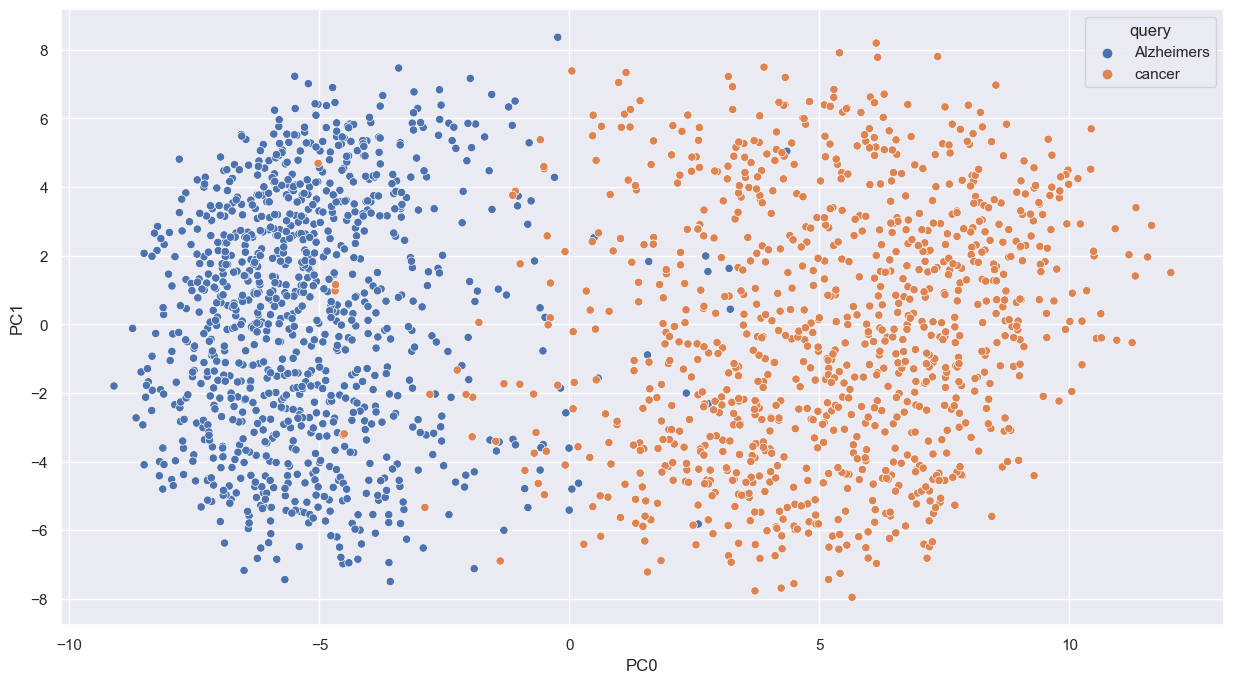

In [16]:
x = embeddings_pca['PC0']
y = embeddings_pca['PC1']
classes = embeddings_pca['query']
colours = ['chocolate', 'blue']

sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(x=x, y=y, hue=classes)

<AxesSubplot:xlabel='PC0', ylabel='PC2'>

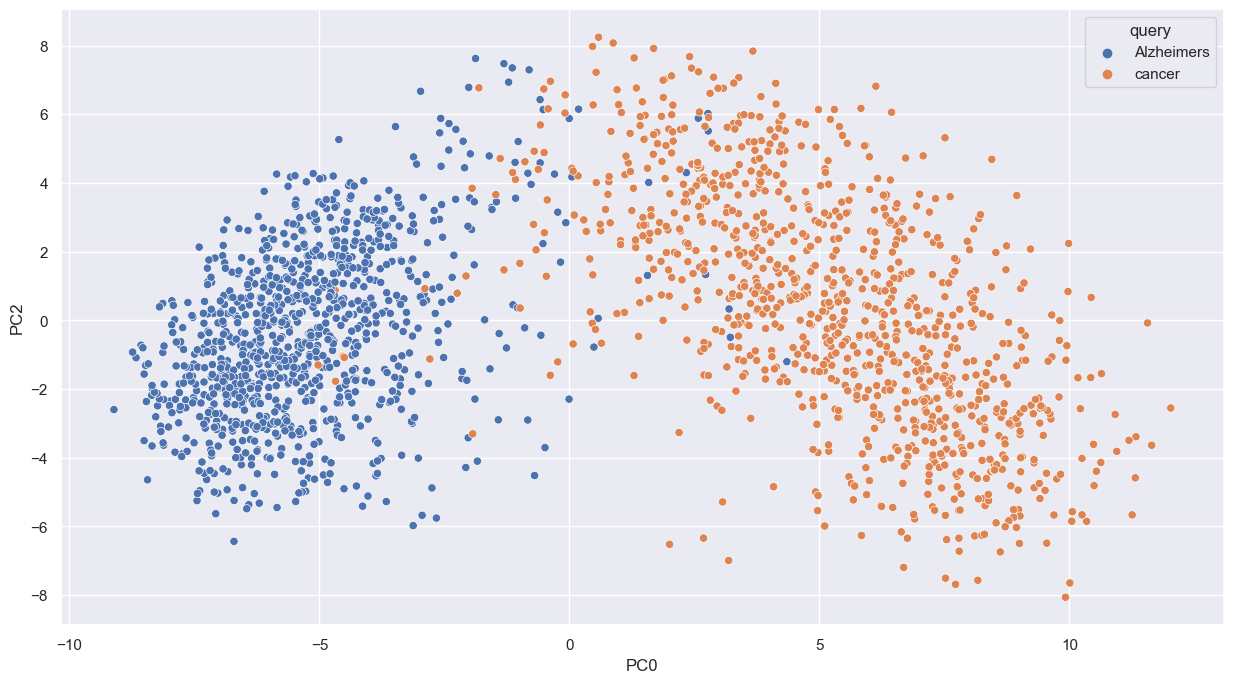

In [17]:
x = embeddings_pca['PC0']
y = embeddings_pca['PC2']
classes = embeddings_pca['query']
colours = ['chocolate', 'blue']

sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(x=x, y=y, hue=classes)


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

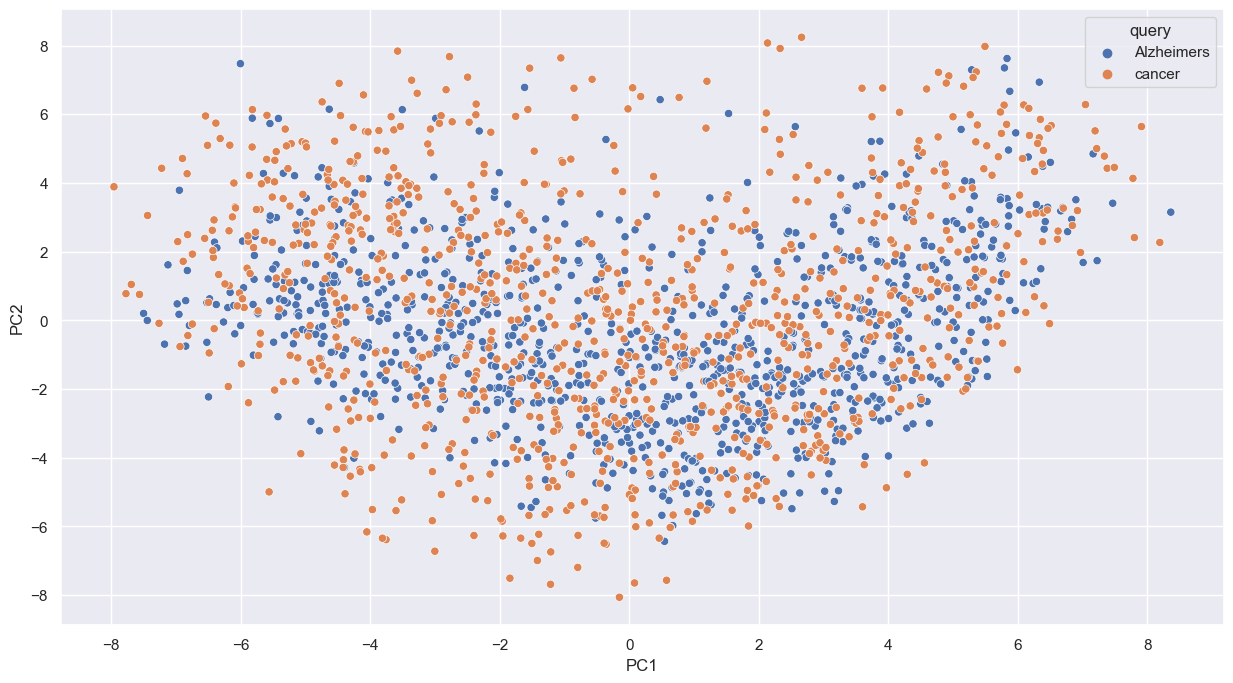

In [18]:
x = embeddings_pca['PC1']
y = embeddings_pca['PC2']
classes = embeddings_pca['query']
colours = ['chocolate', 'blue']

sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(x=x, y=y, hue=classes)

Comment on the separation or lack thereof, and any take-aways from that. **(5 points)**

We process the dictionary of papers to find the SPECTER embeddings of each entry.  
This embedding returns vectors of 768 dimension that express the abstract and title of each entry in the papers dicitonary,  
If the papers are alike, the title and abstract will have sentences that are closer in meaning. Thus, their embedding vectors will also be closer to each other.  
  
However, there are too many dimensions (768) to work with and visualize.  
We thus reduce the dimensions with PCA while still maintaining data meaning.  
This is done by reducing it and choosing the PCA compononents that express the most variance.  
Thus, PC0 will explain more variance of the data than PC1 and PC2.  
(The variance explained by each can be found by looking at the eigenvalues of the covariance matrix of the data.)  
The number of components that are to be considered can be decided based on how much variance needs to be retained.

Thus, when we graph PC0 and PC1 or PC2, we see clear separation along the PC0 (x) axis as it explains most of the variance in the dataset. There are a few points of overlap which makes sense since there are papers working in similar areas of both conditions (cancer and Alzheimers).  
For the graph of PC1 vs PC2, we don't see separation as these components explain far lesser of the variance in the dataset.